In [19]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [20]:
from keras.layers import Embedding, Dense, Dropout, Input, LSTM, Bidirectional,GRU
from keras.layers import MaxPooling1D, Conv1D, Flatten
from keras.preprocessing import sequence, text
from keras.models import Model
from keras.utils import np_utils
from keras.callbacks import Callback

from gensim.models.keyedvectors import KeyedVectors
from sklearn import preprocessing
from time import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import csv

from keras import optimizers

from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

from sklearn.utils import class_weight

from sklearn import preprocessing
from sklearn.metrics import (
    classification_report as creport
)


# Data and AraVec2.0 (pre-trained word embeddings model) Loading

In [21]:
#pre-trained word embedding: https://github.com/bakrianoo/aravec/tree/master/AraVec%202.0
"""
Citation:
Abu Bakr Soliman, Kareem Eisa, and Samhaa R. El-Beltagy, “AraVec:
A set of Arabic Word Embedding Models for use in Arabic NLP”,
in proceedings of the 3rd International Conference on 
Arabic Computational Linguistics (ACLing 2017), Dubai, UAE, 2017.
"""
! unzip '/content/drive/MyDrive/tweets_sg_300.zip'  

Archive:  /content/drive/MyDrive/tweets_sg_300.zip
replace tweets_sg_300? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: tweets_sg_300           
  inflating: tweets_sg_300.trainables.syn1neg.npy  
  inflating: tweets_sg_300.wv.vectors.npy  


In [22]:
# Word_embedding_path
embedding_path = '/content/tweets_sg_300'           #Twitter-Skipgram model-300d(trained on 77,600,000 Arabic tweets)

In [23]:
train_data = pd.read_csv('/content/drive/MyDrive/Dataset.csv')
train_data

,Tweet,Class
0,هول هني ذاتن كانو كلاب الفلسطينية ضد حركة امل,hate
1,واحد مكيف إنه النهيق تبعه أموي شو بده يطلع منه,hate
2,هيدا لبناني لإنو عميل طز بهيك بلد معفن,hate
3,حاطين جبران باسيل وقاعدين جبران قال هيك جبران ...,abusive
4,هلق هيدا يلي طلع معك جبران باسيل متل جيري ماهر...,normal
...,...,...
2514,الكيزان زي النازيين واحد :قتلو وعذبو و حكمهم ...,hate
2515,وطنا جميل وشعبنا جميل بس هدونا البال بالسياسة ...,normal
2516,طيب شو القيمة يلي بيستفيدها المجتمع لو النسوان...,normal
2517,مارسيل غانم انتحر إعلامياً للتو ظهر عن طريق ال...,hate


In [24]:
print("Train data shape: {}".format(train_data.shape))

Train data shape: (2519, 2)


In [25]:
def get_embedding_matrix(word_index, embedding_index, vocab_dim):
    print('Building embedding matrix...')
    embedding_matrix = np.zeros((len(word_index) + 1, vocab_dim))
    for word, i in word_index.items():
        try:
            embedding_matrix[i] = embedding_index.get_vector(word)
        except:
            pass
    print('Embedding matrix built.') 
    #print("Word index", word_index.items())
    #print(embedding_matrix) 
    return embedding_matrix


def get_init_parameters(path, ext=None):
    if ext == 'vec':
        word_model = KeyedVectors.load_word2vec_format(path).wv
    else:
        word_model = KeyedVectors.load(path).wv
    n_words = len(word_model.vocab)
    vocab_dim = word_model[word_model.index2word[0]].shape[0]
    index_dict = dict()
    for i in range(n_words):
        index_dict[word_model.index2word[i]] = i+1
    print('Number of words in the word embedding',n_words)
    #print('word_model', word_model)
    #print("index_dict",index_dict)
    return word_model, index_dict, n_words, vocab_dim

def get_max_length(text_data, return_line=False):
    max_length = 0
    long_line = ""
    for line in text_data:
        new = len(line.split())
        if new > max_length:
            max_length = new
            long_line = line
    if return_line:
        return long_line, max_length
    else:
        return max_length
    print("max",long_line,max_length)

def load_datasets(data_paths, header=True):
    x = []
    y = []
    for data_path in data_paths:
        with open(data_path, 'r') as f:
            for line in f:
                if header:
                    header = False
                else:
                    temp = line.split(',')
                    x.append(temp[0])
                    y.append(temp[1].replace('\n', ''))
    max_length = get_max_length(x)
    print('Max length:', max_length)
    return x,y, max_length

def get_train_test(train_raw_text, test_raw_text, n_words, max_length):
    tokenizer = text.Tokenizer(num_words=n_words)
    tokenizer.fit_on_texts(list(train_raw_text))
    word_index = tokenizer.word_index
   
    train_tokenized = tokenizer.texts_to_sequences(train_raw_text)
    test_tokenized = tokenizer.texts_to_sequences(test_raw_text)

    return sequence.pad_sequences(train_tokenized, maxlen=max_length, padding='post', truncating='post'),\
           sequence.pad_sequences(test_tokenized, maxlen=max_length, padding='post', truncating='post'),\
           word_index

def class_str_2_ind(x_train, x_test, y_train, y_test, classes, n_words, max_length):
    print('Converting data to trainable form...')
    y_encoder = preprocessing.LabelEncoder()
    y_encoder.fit(classes)
    y_train = y_encoder.transform(y_train)
    y_test = y_encoder.transform(y_test)
    #print(y_train)
    #print(y_test)
    train_y_cat = np_utils.to_categorical(y_train, len(classes))
    x_vec_train, x_vec_test, word_index = get_train_test(x_train, x_test, n_words, max_length)
    print('Number of training examples: ' + str(len(x_vec_train)))
    print('Number of testing examples: ' + str(len(x_vec_test)))
    return x_vec_train, x_vec_test, y_train, y_test, train_y_cat, word_index

In [26]:
WORD_MODEL, _, MAX_FEATURES, EMBED_SIZE = get_init_parameters(embedding_path) 

Number of words in the word embedding 331679


In [27]:
# load train data
train_data_path=["/content/drive/MyDrive/OSACT4"]
X, y, MAX_TEXT_LENGTH = load_datasets(train_data_path)
CLASSES_LIST = np.unique(y)
print('Label categories: ' + str(CLASSES_LIST))

Max length: 58
Label categories: ['abusive' 'hate' 'normal']


In [28]:
MAX_TEXT_LENGTH=58

In [29]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [30]:
X_train, X_test, y_train, y_test, train_y_cat, word_index = class_str_2_ind(X_train, X_test, y_train, y_test, CLASSES_LIST, MAX_FEATURES, MAX_TEXT_LENGTH)
test_cat_y = np_utils.to_categorical(y_test, len(CLASSES_LIST))

Converting data to trainable form...
Number of training examples: 2015
Number of testing examples: 504


In [31]:
print("Tokens number: "+ str(len(word_index)))

Tokens number: 10605


In [32]:
# Sequence length
print("Original sequence length: "+str(MAX_TEXT_LENGTH))

Original sequence length: 58


In [33]:
def get_model(embedding_weights, word_index, vocab_dim, max_length,layer, dropout, optimizer, print_summary=True):
    """
    Create Neural Network With an Embedding layer
    """
    inp = Input(shape=(max_length,))
    model = Embedding(input_dim=len(word_index)+1,
                      output_dim=vocab_dim,
                      trainable=False,
                      weights=[embedding_weights])(inp)
    model = layer(model)
    model = Dropout(dropout)(model)       
    model = Flatten()(model)
    model = Dense(3, activation='sigmoid')(model)
    model = Model(inputs=inp, outputs=model)
    
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    if print_summary:
        model.summary()
    return model


def get_main_model(word_index, WORD_MODEL, EMBED_SIZE, MAX_TEXT_LENGTH, 
                   layer, dropout,optimizer):
   
    tmp = get_embedding_matrix(word_index, WORD_MODEL, EMBED_SIZE)
    model = get_model(tmp, word_index, EMBED_SIZE, MAX_TEXT_LENGTH, 
                      layer, dropout, optimizer= optimizer ,print_summary=True)
    return model

class TestCallback(Callback):
    def __init__(self, test_data):
        self.test_data = test_data

    def on_epoch_end(self, epoch, logs={}):
        x, y = self.test_data
        loss, acc = self.model.evaluate(x, y, verbose=0)
        print('\nTesting loss: {}, acc: {}\n'.format(loss, acc))

def train_fit_predict(model, x_train, x_test, y_train, y_test, class_weight, batch_size, epochs, TestCallback=TestCallback):
   
    history = model.fit(x_train, y_train,
                        batch_size=batch_size,
                        epochs=epochs, verbose=1,
                        validation_data=(x_test, y_test),
                        class_weight=class_weight,
                        callbacks=[TestCallback((x_test, y_test))])
    return history, model

#### Note: the prior work is the same for all of the neural learning models.

#  RNN (LSTM) Model

In [34]:
model = get_main_model(word_index, WORD_MODEL, EMBED_SIZE, MAX_TEXT_LENGTH, 
                       layer= LSTM(units=16, return_sequences=True, return_state=False), dropout=0.5, 
                       optimizer= optimizers.Adam(0.001))

Building embedding matrix...
Embedding matrix built.
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 58)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 58, 300)           3181800   
_________________________________________________________________
lstm (LSTM)                  (None, 58, 16)            20288     
_________________________________________________________________
dropout (Dropout)            (None, 58, 16)            0         
_________________________________________________________________
flatten (Flatten)            (None, 928)               0         
_________________________________________________________________
dense (Dense)                (None, 3)                 2787      
Total params: 3,204,875
Trainable params: 23,075
Non-trainable params: 3,1

In [35]:
X_train.shape

(2015, 58)

In [36]:
X_test.shape

(504, 58)

In [37]:
time_start = time()
history, model = train_fit_predict(model,
                               X_train[:, :MAX_TEXT_LENGTH],
                               X_test[:, :MAX_TEXT_LENGTH],
                               train_y_cat, test_cat_y, class_weight=None,
                               batch_size=500, epochs=20)
time_start = time() - time_start

print("Took : "+str(np.round(time_start, 2))+" (s)") 

Epoch 1/20
5/5 [==============================] - 31s 173ms/step - loss: 1.0954 - accuracy: 0.3639 - val_loss: 1.0739 - val_accuracy: 0.4980

Testing loss: 1.0738753080368042, acc: 0.4980158805847168

Epoch 2/20
5/5 [==============================] - 0s 47ms/step - loss: 1.0651 - accuracy: 0.4448 - val_loss: 1.0548 - val_accuracy: 0.5397

Testing loss: 1.054807424545288, acc: 0.5396825671195984

Epoch 3/20
5/5 [==============================] - 0s 44ms/step - loss: 1.0407 - accuracy: 0.4877 - val_loss: 1.0334 - val_accuracy: 0.5655

Testing loss: 1.0333755016326904, acc: 0.5654761791229248

Epoch 4/20
5/5 [==============================] - 0s 43ms/step - loss: 1.0044 - accuracy: 0.5526 - val_loss: 1.0028 - val_accuracy: 0.6032

Testing loss: 1.00275719165802, acc: 0.60317462682724

Epoch 5/20
5/5 [==============================] - 0s 43ms/step - loss: 0.9723 - accuracy: 0.5691 - val_loss: 0.9656 - val_accuracy: 0.6032

Testing loss: 0.9655624628067017, acc: 0.60317462682724

Epoch 6/20

In [38]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [39]:
model.evaluate(X_test[:, :MAX_TEXT_LENGTH], test_cat_y, batch_size=1000)

1/1 [==============================] - 0s 39ms/step - loss: 0.7273 - accuracy: 0.6766


[0.7272546887397766, 0.6765872836112976]

In [40]:
y_pred = np.argmax(model.predict(X_test[:, :MAX_TEXT_LENGTH]), axis=1)

print(creport(np.argmax(test_cat_y, axis=1), y_pred,target_names=["normal", "abusive", "hate"],digits=4))

              precision    recall  f1-score   support

      normal     0.6102    0.6243    0.6171       173
     abusive     0.7075    0.6380    0.6710       163
        hate     0.7167    0.7679    0.7414       168

    accuracy                         0.6766       504
   macro avg     0.6781    0.6767    0.6765       504
weighted avg     0.6771    0.6766    0.6760       504



In [41]:
n = np.argmin(history.history['val_loss'])

print("Optimal epoch : {}".format(n))
print("Accuracy on train : {} %".format(np.round(history.history['accuracy'][n]*100, 2)))
print("Accuracy on val : {} %".format(np.round(history.history['val_accuracy'][n]*100, 2)))
print("Loss on train : {}".format(np.round(history.history['loss'][n]*100, 2)))
print("Loss on Val : {}".format(np.round(history.history['val_loss'][n]*100, 2)))

Optimal epoch : 19
Accuracy on train : 71.36 %
Accuracy on val : 67.66 %
Loss on train : 67.6
Loss on Val : 72.73


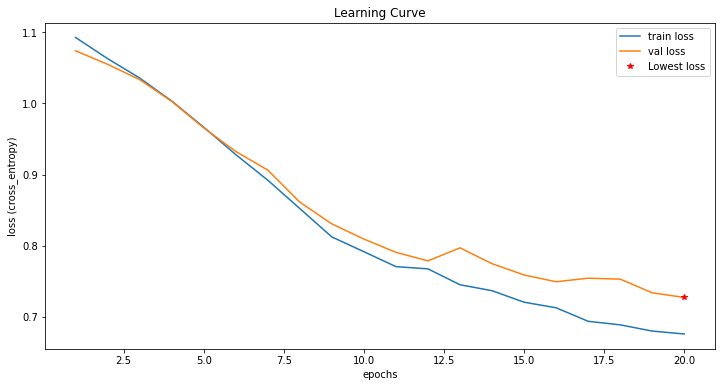

In [42]:
plt.figure("Loss Plot", figsize=(12, 6))
plt.plot(range(1, len(history.history['loss'])+1), history.history['loss'], label="train loss")
plt.plot(range(1, len(history.history['val_loss'])+1), history.history['val_loss'], label="val loss")
plt.plot(n+1,history.history["val_loss"][n],"r*", label="Lowest loss")
plt.legend()
plt.title("Learning Curve")
plt.ylabel("loss (cross_entropy)")
plt.xlabel("epochs")
plt.show();

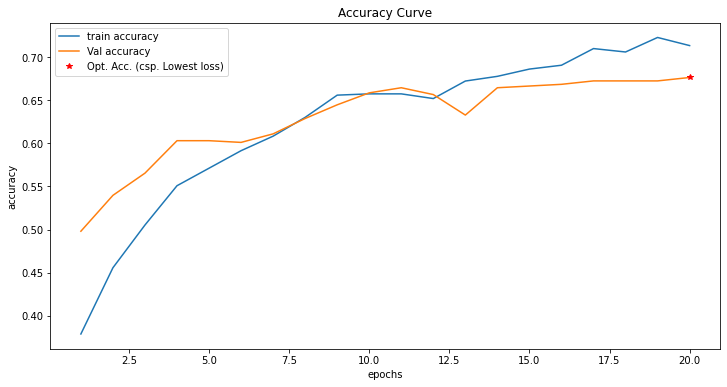

In [43]:
plt.figure("Accuracy Plot", figsize=(12, 6))
plt.plot(range(1, len(history.history['accuracy'])+1), history.history['accuracy'], label="train accuracy")
plt.plot(range(1, len(history.history['val_accuracy'])+1), history.history['val_accuracy'], label="Val accuracy")
plt.plot(n+1,history.history["val_accuracy"][n],"r*", label="Opt. Acc. (csp. Lowest loss)")
plt.legend()
plt.title("Accuracy Curve")
plt.ylabel("accuracy")
plt.xlabel("epochs")
plt.show()

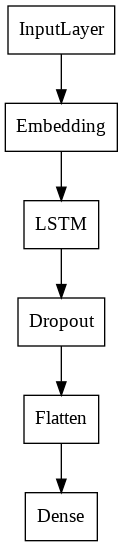

In [44]:
from keras.utils import plot_model
plot_model(model, to_file='RNN_LSTM_model.png', show_shapes=False, show_layer_names=False)

# RNN (BLSTM) Model 


In [45]:
model = get_main_model(word_index, WORD_MODEL, EMBED_SIZE, MAX_TEXT_LENGTH, 
                       layer= Bidirectional(LSTM(units=32, return_sequences=True, return_state=False)), 
                       dropout=0.2, optimizer=optimizers.Adam())

Building embedding matrix...
Embedding matrix built.
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 58)]              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 58, 300)           3181800   
_________________________________________________________________
bidirectional (Bidirectional (None, 58, 64)            85248     
_________________________________________________________________
dropout_1 (Dropout)          (None, 58, 64)            0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 3712)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 11139     
Total params: 3,278,187
Trainable params: 96,387
Non-trainable params: 3

In [46]:
time_start = time()
history, model = train_fit_predict(model,
                               X_train[:, :MAX_TEXT_LENGTH],
                               X_test[:, :MAX_TEXT_LENGTH],
                               train_y_cat, test_cat_y, class_weight=None,
                               batch_size=500, epochs=20)
time_start = time() - time_start

print("Took : "+str(np.round(time_start, 2))+" (s)") 

Epoch 1/20
5/5 [==============================] - 4s 288ms/step - loss: 1.0748 - accuracy: 0.4446 - val_loss: 1.0284 - val_accuracy: 0.5575

Testing loss: 1.0284327268600464, acc: 0.557539701461792

Epoch 2/20
5/5 [==============================] - 0s 74ms/step - loss: 0.9897 - accuracy: 0.5534 - val_loss: 0.9615 - val_accuracy: 0.5933

Testing loss: 0.9614521265029907, acc: 0.5932539701461792

Epoch 3/20
5/5 [==============================] - 0s 71ms/step - loss: 0.9125 - accuracy: 0.6044 - val_loss: 0.9097 - val_accuracy: 0.5952

Testing loss: 0.909692108631134, acc: 0.5952380895614624

Epoch 4/20
5/5 [==============================] - 0s 67ms/step - loss: 0.8436 - accuracy: 0.6407 - val_loss: 0.8299 - val_accuracy: 0.6052

Testing loss: 0.8298861980438232, acc: 0.6051587462425232

Epoch 5/20
5/5 [==============================] - 0s 70ms/step - loss: 0.7852 - accuracy: 0.6525 - val_loss: 0.7959 - val_accuracy: 0.6369

Testing loss: 0.7959484457969666, acc: 0.636904776096344

Epoch 6

In [47]:
model.evaluate(X_test[:, :MAX_TEXT_LENGTH], test_cat_y, batch_size=1000)

1/1 [==============================] - 0s 40ms/step - loss: 0.6835 - accuracy: 0.6984


[0.6834930777549744, 0.6984127163887024]

In [48]:
y_pred = np.argmax(model.predict(X_test[:, :MAX_TEXT_LENGTH]), axis=1)

print(creport(np.argmax(test_cat_y, axis=1), y_pred,target_names=["normal", "abusive", "hate"],digits=4))

              precision    recall  f1-score   support

      normal     0.6648    0.6763    0.6705       173
     abusive     0.7788    0.5399    0.6377       163
        hate     0.6837    0.8750    0.7676       168

    accuracy                         0.6984       504
   macro avg     0.7091    0.6971    0.6919       504
weighted avg     0.7080    0.6984    0.6923       504



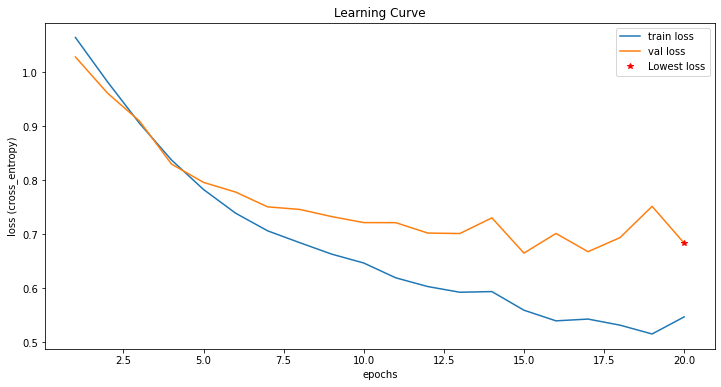

In [49]:
plt.figure("Loss Plot", figsize=(12, 6))
plt.plot(range(1, len(history.history['loss'])+1), history.history['loss'], label="train loss")
plt.plot(range(1, len(history.history['val_loss'])+1), history.history['val_loss'], label="val loss")
plt.plot(n+1,history.history["val_loss"][n],"r*", label="Lowest loss")
plt.legend()
plt.title("Learning Curve")
plt.ylabel("loss (cross_entropy)")
plt.xlabel("epochs")
plt.show();

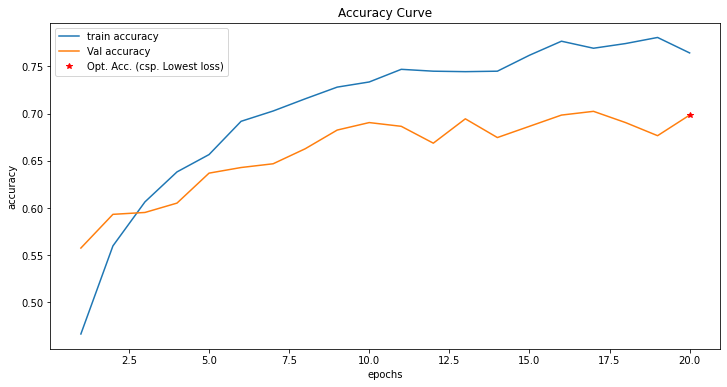

In [50]:
plt.figure("Accuracy Plot", figsize=(12, 6))
plt.plot(range(1, len(history.history['accuracy'])+1), history.history['accuracy'], label="train accuracy")
plt.plot(range(1, len(history.history['val_accuracy'])+1), history.history['val_accuracy'], label="Val accuracy")
plt.plot(n+1,history.history["val_accuracy"][n],"r*", label="Opt. Acc. (csp. Lowest loss)")
plt.legend()
plt.title("Accuracy Curve")
plt.ylabel("accuracy")
plt.xlabel("epochs")
plt.show()

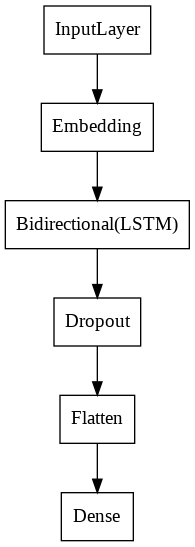

In [51]:
plot_model(model, to_file='RNN_BLSTM_model.png', show_shapes=False, show_layer_names=False)

# RNN (GRU) Model


In [52]:
model = get_main_model(word_index, WORD_MODEL, EMBED_SIZE, MAX_TEXT_LENGTH, 
                       layer= GRU(units=16, return_sequences=True, return_state=False), 
                       dropout=0.5, optimizer=optimizers.Adam())

Building embedding matrix...
Embedding matrix built.
Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 58)]              0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 58, 300)           3181800   
_________________________________________________________________
gru (GRU)                    (None, 58, 16)            15264     
_________________________________________________________________
dropout_2 (Dropout)          (None, 58, 16)            0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 928)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 2787      
Total params: 3,199,851
Trainable params: 18,051
Non-trainable params: 3

In [53]:
time_start = time()
history, model = train_fit_predict(model,
                               X_train[:, :MAX_TEXT_LENGTH],
                               X_test[:, :MAX_TEXT_LENGTH],
                               train_y_cat, test_cat_y, class_weight=None,
                               batch_size=500, epochs=20)
time_start = time() - time_start

print("Took : "+str(np.round(time_start, 2))+" (s)") 

Epoch 1/20
5/5 [==============================] - 2s 157ms/step - loss: 1.1100 - accuracy: 0.3206 - val_loss: 1.0795 - val_accuracy: 0.4187

Testing loss: 1.079501986503601, acc: 0.4186508059501648

Epoch 2/20
5/5 [==============================] - 0s 46ms/step - loss: 1.0717 - accuracy: 0.4178 - val_loss: 1.0563 - val_accuracy: 0.4841

Testing loss: 1.0563032627105713, acc: 0.4841269850730896

Epoch 3/20
5/5 [==============================] - 0s 44ms/step - loss: 1.0489 - accuracy: 0.4756 - val_loss: 1.0332 - val_accuracy: 0.5417

Testing loss: 1.0332411527633667, acc: 0.5416666865348816

Epoch 4/20
5/5 [==============================] - 0s 45ms/step - loss: 1.0167 - accuracy: 0.5102 - val_loss: 1.0058 - val_accuracy: 0.5655

Testing loss: 1.005839228630066, acc: 0.5654761791229248

Epoch 5/20
5/5 [==============================] - 0s 43ms/step - loss: 0.9863 - accuracy: 0.5439 - val_loss: 0.9726 - val_accuracy: 0.5913

Testing loss: 0.9726043343544006, acc: 0.591269850730896

Epoch 6

In [54]:
model.evaluate(X_test[:, :MAX_TEXT_LENGTH], test_cat_y, batch_size=1000)

1/1 [==============================] - 0s 36ms/step - loss: 0.6923 - accuracy: 0.7163


[0.6922999620437622, 0.716269850730896]

In [55]:
y_pred = np.argmax(model.predict(X_test[:, :MAX_TEXT_LENGTH]), axis=1)

print(creport(np.argmax(test_cat_y, axis=1), y_pred,target_names=["normal", "abusive", "hate"],digits=4))

              precision    recall  f1-score   support

      normal     0.6116    0.7919    0.6902       173
     abusive     0.8246    0.5767    0.6787       163
        hate     0.7831    0.7738    0.7784       168

    accuracy                         0.7163       504
   macro avg     0.7398    0.7141    0.7158       504
weighted avg     0.7377    0.7163    0.7159       504



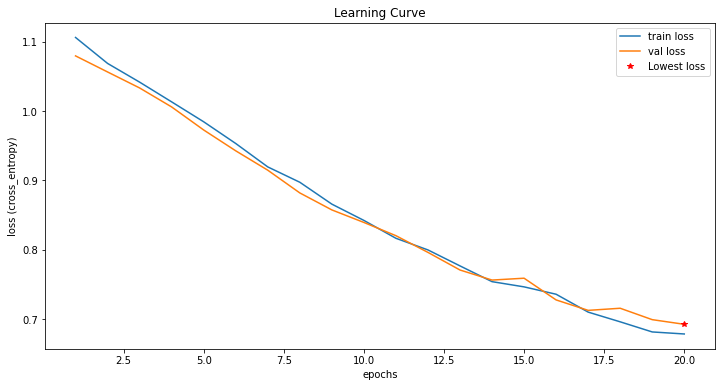

In [56]:
plt.figure("Loss Plot", figsize=(12, 6))
plt.plot(range(1, len(history.history['loss'])+1), history.history['loss'], label="train loss")
plt.plot(range(1, len(history.history['val_loss'])+1), history.history['val_loss'], label="val loss")
plt.plot(n+1,history.history["val_loss"][n],"r*", label="Lowest loss")
plt.legend()
plt.title("Learning Curve")
plt.ylabel("loss (cross_entropy)")
plt.xlabel("epochs")
plt.show();

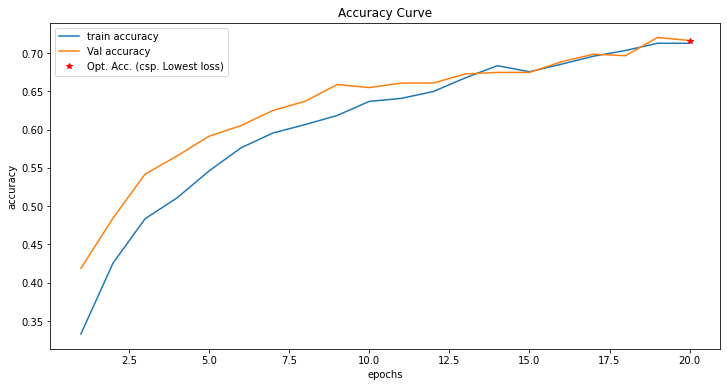

In [57]:
plt.figure("Accuracy Plot", figsize=(12, 6))
plt.plot(range(1, len(history.history['accuracy'])+1), history.history['accuracy'], label="train accuracy")
plt.plot(range(1, len(history.history['val_accuracy'])+1), history.history['val_accuracy'], label="Val accuracy")
plt.plot(n+1,history.history["val_accuracy"][n],"r*", label="Opt. Acc. (csp. Lowest loss)")
plt.legend()
plt.title("Accuracy Curve")
plt.ylabel("accuracy")
plt.xlabel("epochs")
plt.show()

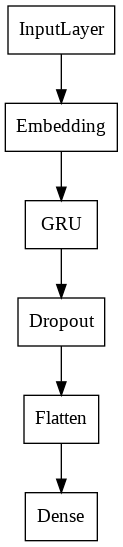

In [58]:
plot_model(model, to_file='RNN_GRU_model.png', show_shapes=False, show_layer_names=False)